In [173]:
import emo_utils
import numpy as np
import time
import matplotlib.pyplot as plt

class Linear:
    def __init__(self, m, n):
        self.weight = np.random.randn(m, n) * np.sqrt(2 / m)
        self.bias = np.random.randn(n) * 0.01
        
        self.first_moment = np.zeros((m, n))
        self.second_moment = np.zeros((m, n))
        
        self.bias_first_moment = np.zeros(n)
        self.bias_second_moment = np.zeros(n)
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.learning_rate = 1e-4
        
        self.step = 0
        
        self.input = None
        
    def forward(self, input):
        self.input = input
        return np.dot(input, self.weight) + self.bias
    
    def backward(self, output_gradient):
        self.step += 1
        
        input_gradient = np.dot(output_gradient, self.weight.T)
        weight_gradient = np.dot(self.input.T, output_gradient)
        bias_gradient = np.sum(output_gradient, axis=0)
        
        self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * weight_gradient
        self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * weight_gradient * weight_gradient
        
        self.bias_first_moment = self.beta1 * self.bias_first_moment + (1 - self.beta1) * bias_gradient
        self.bias_second_moment = self.beta2 * self.bias_second_moment + (1 - self.beta2) * bias_gradient * bias_gradient
        
        first_unbias = self.first_moment / (1 - self.beta1 ** self.step)
        second_unbias = self.second_moment / (1 - self.beta2 ** self.step)
        
        bias_first_unbias = self.bias_first_moment / (1 - self.beta1 ** self.step)
        bias_second_unbias = self.bias_second_moment / (1 - self.beta2 ** self.step) 
        
        self.weight -= self.learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)
        self.bias -= self.learning_rate * bias_first_unbias / (np.sqrt(bias_second_unbias) + 1e-7)
        
        return input_gradient
    

class Softmax:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        self.input = input
        max_input = np.max(input, axis=1, keepdims=True)
        exp_input = np.exp(input-max_input)
        self.output = exp_input / np.sum(exp_input, axis=1, keepdims=True)
        
        return self.output
    
    def backward(self, output_gradient):
        return self.output - output_gradient

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    k = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred)) / k
    return loss

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [174]:
class LSTM:
    def __init__(self, input_size, hidden_size, adam=False):
        self.hidden_size = hidden_size
        self.input_size = input_size
        combined_size = hidden_size + input_size
        self.adam = adam
        
        self.wf = np.random.randn(hidden_size, combined_size) * np.sqrt(1 / hidden_size)
        self.wi = np.random.randn(hidden_size, combined_size) * np.sqrt(1 / hidden_size)
        self.wc = np.random.randn(hidden_size, combined_size) * np.sqrt(1 / hidden_size)
        self.wo = np.random.randn(hidden_size, combined_size) * np.sqrt(1 / hidden_size)
        
        self.bf = np.ones((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))

        self.first_moment = np.zeros((4, hidden_size, combined_size))
        self.second_moment = np.zeros((4, hidden_size, combined_size))
        
        self.bias_first_moment = np.zeros((4, hidden_size, 1))
        self.bias_second_moment = np.zeros((4, hidden_size, 1))
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.adam_learning_rate = 1e-4
        
        self.sgd_learning_rate = 5e-3
        
        self.step = 0
    
    def forward(self, input_c, input_h, input_x):
        hx = np.concatenate([input_h, input_x], axis=0)
        
        f_gate = sigmoid(np.dot(self.wf, hx) + self.bf)
        i_gate = sigmoid(np.dot(self.wi, hx) + self.bi)
        o_gate = sigmoid(np.dot(self.wo, hx) + self.bo)
        temp_c = np.tanh(np.dot(self.wc, hx) + self.bc)
        
        output_c = input_c * f_gate + temp_c * i_gate
        output_h = np.tanh(output_c) * o_gate
        
        return (output_c, output_h)
    
    def backward(self, input_c, input_h, input_x, output_c_gradient, output_h_gradient):
        hx = np.concatenate([input_h, input_x], axis=0)
        
        f_gate = sigmoid(np.dot(self.wf, hx) + self.bf)
        i_gate = sigmoid(np.dot(self.wi, hx) + self.bi)
        o_gate = sigmoid(np.dot(self.wo, hx) + self.bo)
        temp_c = np.tanh(np.dot(self.wc, hx) + self.bc)
        
        output_c = input_c * f_gate + temp_c * i_gate
        output_h = np.tanh(output_c) * o_gate
        
        o_gate_gradient = output_h_gradient * np.tanh(output_c)
        o_gate_gradient_unsig = o_gate_gradient * o_gate * (1 - o_gate)
        wo_gradient = np.dot(o_gate_gradient_unsig, hx.T)
        hx_gradient_from_o_gate = np.dot(self.wo.T, o_gate_gradient_unsig)
        
        c_gradient_from_output_h = output_h_gradient * o_gate
        c_gradient_from_output_h_untanh = c_gradient_from_output_h * (1 - (np.tanh(output_c)) ** 2)
        input_c_gradient = (output_c_gradient + c_gradient_from_output_h_untanh) * f_gate
        
        f_gate_gradient = (output_c_gradient + c_gradient_from_output_h_untanh) * input_c
        f_gate_gradient_unsig = f_gate_gradient * f_gate * (1 - f_gate)
        wf_gradient = np.dot(f_gate_gradient_unsig, hx.T)
        hx_gradient_from_f_gate = np.dot(self.wf.T, f_gate_gradient_unsig)
        
        i_gate_gradient = (output_c_gradient + c_gradient_from_output_h_untanh) * temp_c
        i_gate_gradient_unsig = i_gate_gradient * i_gate * (1 - i_gate)
        wi_gradient = np.dot(i_gate_gradient_unsig, hx.T)
        hx_gradient_from_i_gate = np.dot(self.wi.T, i_gate_gradient_unsig)
        
        temp_c_gradient = (output_c_gradient + c_gradient_from_output_h_untanh) * i_gate
        temp_c_gradient_untanh = temp_c_gradient * (1 - temp_c ** 2)
        wc_gradient = np.dot(temp_c_gradient_untanh, hx.T)
        hx_gradient_from_temp_c = np.dot(self.wc.T, temp_c_gradient_untanh)
        
        hx_gradient = hx_gradient_from_o_gate + hx_gradient_from_f_gate + hx_gradient_from_i_gate + hx_gradient_from_temp_c
        input_h_gradient = hx_gradient[0:self.hidden_size,:]
        input_x_gradient = hx_gradient[self.hidden_size:, :]
        
        return input_c_gradient, input_h_gradient, input_x_gradient, wf_gradient, wi_gradient, wo_gradient, wc_gradient, f_gate_gradient_unsig, i_gate_gradient_unsig, o_gate_gradient_unsig, temp_c_gradient_untanh
    
    def apply_gradient(self, wf, wi, wo, wc, bf, bi, bo, bc):
        if self.adam:
            self.step += 1
            weight_gradient = np.array([wf, wi, wo, wc])
            bias_gradient = np.array([bf, bi, bo, bc])
            
            self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * weight_gradient
            self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * weight_gradient * weight_gradient
            
            self.bias_first_moment = self.beta1 * self.bias_first_moment + (1 - self.beta1) * bias_gradient
            self.bias_second_moment = self.beta2 * self.bias_second_moment + (1 - self.beta2) * bias_gradient * bias_gradient
            
            first_unbias = self.first_moment / (1 - self.beta1 ** self.step)
            second_unbias = self.second_moment / (1 - self.beta2 ** self.step)
            
            bias_first_unbias = self.bias_first_moment / (1 - self.beta1 ** self.step)
            bias_second_unbias = self.bias_second_moment / (1 - self.beta2 ** self.step)
            
            total_weight_gradient = self.adam_learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)
            total_bias_gradient = self.adam_learning_rate * bias_first_unbias / (np.sqrt(bias_second_unbias) + 1e-7)
            
            self.wf -= total_weight_gradient[0,:,:]
            self.wi -= total_weight_gradient[1,:,:]
            self.wo -= total_weight_gradient[2,:,:]
            self.wc -= total_weight_gradient[3,:,:]
            
            self.bf -= total_bias_gradient[0,:,:]
            self.bi -= total_bias_gradient[1,:,:]
            self.bo -= total_bias_gradient[2,:,:]
            self.bc -= total_bias_gradient[3,:,:]
            
        else:
            self.wf -= self.sgd_learning_rate * wf
            self.wi -= self.sgd_learning_rate * wi
            self.wo -= self.sgd_learning_rate * wo
            self.wc -= self.sgd_learning_rate * wc
            
            self.bf -= self.sgd_learning_rate * bf
            self.bi -= self.sgd_learning_rate * bi
            self.bo -= self.sgd_learning_rate * bo
            self.bc -= self.sgd_learning_rate * bc

In [175]:
class RNN:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size
        self.input_size = input_size
        combined_size = hidden_size + input_size
        
        self.weight = np.random.randn(hidden_size, combined_size) * np.sqrt(1 / hidden_size)
        self.bias = np.zeros((hidden_size, 1))
        
        self.learning_rate = 5e-4
    
    def forward(self, input_h, input_x):
        hx = np.concatenate([input_h, input_x], axis=0)
        return np.tanh(np.dot(self.weight, hx) + self.bias)
    
    def backward(self, input_h, input_x, output_gradient):
        hx = np.concatenate([input_h, input_x], axis=0)
        
        output_gradient_untanh = output_gradient * (1 - (np.tanh(np.dot(self.weight, hx) + self.bias)) ** 2)
        
        weight_gradient = np.dot(output_gradient_untanh, hx.T)
        bias_gradient = output_gradient_untanh
        
        hx_gradient = np.dot(self.weight.T, output_gradient_untanh)
        h_gradient = hx_gradient[:self.hidden_size,:]
        x_gradient = hx_gradient[self.hidden_size:,:]
        
        return h_gradient, x_gradient, weight_gradient, bias_gradient
        
    def apply_gradient(self, weight_gradient, bias_gradient):
        self.weight -= self.learning_rate * weight_gradient
        self.bias -= self.learning_rate * bias_gradient

In [176]:
class Dropout:
    def __init__(self, dropout_rate, shape, active):
        self.dropout_rate = dropout_rate
        self.shape = shape
        self.active = active
    
    def create_mask(self):
        mask = np.random.binomial(1, 1 - self.dropout_rate, size=self.shape)
        return mask

    def forward(self, input, mask, training):
        if self.active and training:
            return input * mask / (1 - self.dropout_rate)
        else:
            return input

    def backward(self, output_gradient, mask):
        if self.active:
            return output_gradient * mask
        else:
            return output_gradient

In [177]:
class ModelBasedLSTM:
    def __init__(self, adam=False, glove=50, dropout=False):
        self.lstm1 = LSTM(glove, 2*glove, adam)
        self.lstm2 = LSTM(2*glove, 4*glove, adam)
        self.dropout1 = Dropout(0.5, (2*glove, 1), dropout)
        self.dropout2 = Dropout(0.5, (4*glove, 1), dropout)
        self.linear = Linear(4*glove, 5)
        self.softmax = Softmax()
        
        self.input1 = []
        self.h1 = []
        self.c1 = []
        self.input2 = []
        self.h2 = []
        self.c2 = []
        self.mask1 = []
        self.mask2 = None
        self.sentence_len = 0
        
        if glove == 50:
            self.word_to_vec_map = emo_utils.read_glove_vecs('glove.6B.50d.txt')[2]
        elif glove == 100:
            self.word_to_vec_map = emo_utils.read_glove_vecs('glove.6B.100d.txt')[2]
        else:
            assert(False)
        
    def _forward(self, sentence, training):
        self.input1 = []
        self.h1 = [np.zeros((self.lstm1.hidden_size, 1))]
        self.c1 = [np.zeros((self.lstm1.hidden_size, 1))]
        self.input2 = []
        self.h2 = [np.zeros((self.lstm2.hidden_size, 1))]
        self.c2 = [np.zeros((self.lstm2.hidden_size, 1))]
        self.mask1 = []
        self.mask2 = None
        self.sentence_len = len(sentence.split())
        
        for word in sentence.split():
            input = self.word_to_vec_map[word]
            input = input.reshape(-1, 1)
            self.input1.append(input)
        
        for input in self.input1:
            c, h = self.lstm1.forward(self.c1[-1], self.h1[-1], input)
            
            self.c1.append(c)
            self.h1.append(h)
        
        for h in self.h1[1:]:
            mask = self.dropout1.create_mask()
            self.mask1.append(mask)
            self.input2.append(self.dropout1.forward(h, mask, training))
        
        for input in self.input2:
            c, h = self.lstm2.forward(self.c2[-1], self.h2[-1], input)
            
            self.c2.append(c)
            self.h2.append(h)
        
        self.mask2 = self.dropout2.create_mask()
        input = self.dropout2.forward(self.h2[-1], self.mask2, training)
        
        input = input.reshape(1, -1)
        
        input = self.linear.forward(input)
        
        prediction = self.softmax.forward(input)
        
        return prediction
        
    
    def _backward(self, label):
        output_gradient = self.softmax.backward(label)
        
        output_gradient = self.linear.backward(output_gradient)
        
        c2_gradient = [0] * (self.sentence_len + 1)
        h2_gradient = [0] * (self.sentence_len + 1)
        input2_gradient = [0] * self.sentence_len
        
        total_wf_gradient = 0
        total_wi_gradient = 0
        total_wo_gradient = 0
        total_wc_gradient = 0
        
        total_bf_gradient = 0
        total_bi_gradient = 0
        total_bo_gradient = 0
        total_bc_gradient = 0
        
        h2_gradient[-1] = output_gradient.reshape(-1, 1)
        
        for i in range(self.sentence_len-1, -1, -1):
            c2_gradient[i], h2_gradient[i], input2_gradient[i], wf, wi, wo, wc, bf, bi, bo, bc = self.lstm2.backward(self.c2[i], self.h2[i], self.input2[i], c2_gradient[i+1], h2_gradient[i+1])
            
            total_wf_gradient += wf
            total_wi_gradient += wi
            total_wo_gradient += wo
            total_wc_gradient += wc
            
            total_bf_gradient += bf
            total_bi_gradient += bi
            total_bo_gradient += bo
            total_bc_gradient += bc
            
        self.lstm2.apply_gradient(total_wf_gradient, total_wi_gradient, total_wo_gradient, total_wc_gradient, total_bf_gradient, total_bi_gradient, total_bo_gradient, total_bc_gradient)
        
        c1_gradient = [0] * (self.sentence_len + 1)
        h1_gradient = [0] * (self.sentence_len + 1)
        input1_gradient = [0] * self.sentence_len
        
        total_wf_gradient = 0
        total_wi_gradient = 0
        total_wo_gradient = 0
        total_wc_gradient = 0
        
        total_bf_gradient = 0
        total_bi_gradient = 0
        total_bo_gradient = 0
        total_bc_gradient = 0
        
        for i in range(self.sentence_len):
            h1_gradient[i+1] = self.dropout1.backward(input2_gradient[i], self.mask1[i])
            
        for i in range(self.sentence_len-1, -1, -1):
            c1_gradient[i], temp_h1_gradient, input1_gradient[i], wf, wi, wo, wc, bf, bi, bo, bc = self.lstm1.backward(self.c1[i], self.h1[i], self.input1[i], c1_gradient[i+1], h1_gradient[i+1])
            
            h1_gradient[i] += temp_h1_gradient
            
            total_wf_gradient += wf
            total_wi_gradient += wi
            total_wo_gradient += wo
            total_wc_gradient += wc
            
            total_bf_gradient += bf
            total_bi_gradient += bi
            total_bo_gradient += bo
            total_bc_gradient += bc
            
        self.lstm1.apply_gradient(total_wf_gradient, total_wi_gradient, total_wo_gradient, total_wc_gradient, total_bf_gradient, total_bi_gradient, total_bo_gradient, total_bc_gradient)
            
    def train(self, sentence, label):
        prediction = self._forward(sentence, True)
        self._backward(label)
        return prediction
    
    def test(self, sentence):
        return self._forward(sentence, False)

In [178]:
class ModelBasedRNN:
    def __init__(self):
        self.rnn1 = RNN(50, 100)
        self.rnn2 = RNN(100, 200)
        self.linear = Linear(200, 5)
        self.softmax = Softmax()
        
        self.input1 = []
        self.h1 = []
        self.input2 = []
        self.h2 = []
        
        self.sentence_len = 0
        self.word_to_vec_map = emo_utils.read_glove_vecs('glove.6B.50d.txt')[2]

    def _forward(self, sentence):
        self.input1 = []
        self.h1 = [np.zeros((self.rnn1.hidden_size, 1))]
        self.input2 = []
        self.h2 = [np.zeros((self.rnn2.hidden_size, 1))]

        self.sentence_len = len(sentence.split())
        
        for word in sentence.split():
            input = self.word_to_vec_map[word]
            input = input.reshape(-1, 1)
            self.input1.append(input)
            
        for input in self.input1:
            h = self.rnn1.forward(self.h1[-1], input)
            self.h1.append(h)
            self.input2.append(h)
        
        for input in self.input2:
            h = self.rnn2.forward(self.h2[-1], input)
            self.h2.append(h)
        
        input = self.h2[-1].reshape(1, -1)
        
        input = self.linear.forward(input)
        
        prediction = self.softmax.forward(input)
        
        return prediction
    
    def _backward(self, label):
        output_gradient = self.softmax.backward(label)
        output_gradient = self.linear.backward(output_gradient)
        
        h2_gradient = [0] * (self.sentence_len + 1)
        input2_gradient = [0] * self.sentence_len
        
        total_weight_gradient = 0
        total_bias_gradient = 0
        
        h2_gradient[-1] = output_gradient.reshape(-1, 1)
        
        for i in range(self.sentence_len-1, -1, -1):
            h2_gradient[i], input2_gradient[i], weight_gradient, bias_gradient = self.rnn2.backward(self.h2[i], self.input2[i], h2_gradient[i+1])
            
            total_weight_gradient += weight_gradient
            total_bias_gradient += bias_gradient

        self.rnn2.apply_gradient(total_weight_gradient, total_bias_gradient)
        
        h1_gradient = [0] * (self.sentence_len + 1)
        input1_gradient = [0] * self.sentence_len
        
        total_weight_gradient = 0
        total_bias_gradient = 0
        
        h1_gradient[1:] = input2_gradient
            
        for i in range(self.sentence_len-1, -1, -1):
            temp_h1_gradient, input1_gradient[i], weight_gradient, bias_gradient = self.rnn1.backward(self.h1[i], self.input1[i], h1_gradient[i+1])
            
            h1_gradient[i] += temp_h1_gradient
            total_weight_gradient += weight_gradient
            total_bias_gradient += bias_gradient

        self.rnn1.apply_gradient(total_weight_gradient, total_bias_gradient)
    
    def train(self, sentence, label):
        prediction = self._forward(sentence)
        self._backward(label)
        return prediction
    
    def test(self, sentence):
        return self._forward(sentence)

In [179]:
def one_hot_encode(num):
    l = np.zeros((1, 5))
    l[0, num] = 1
    return l

In [180]:
train_sentences, train_labels = emo_utils.read_csv('train_emoji.csv')
test_sentences, test_labels = emo_utils.read_csv('test_emoji.csv')

test_labels_not_encoded = test_labels

temp_labels = []

for i in range(len(train_labels)):
    train_sentences[i] = train_sentences[i].lower()
    temp_labels.append(one_hot_encode(train_labels[i]))

train_labels = np.array(temp_labels)

temp_labels = []

for i in range(len(test_labels)):
    test_sentences[i] = test_sentences[i].replace('\t', '').lower()
    temp_labels.append(one_hot_encode(test_labels[i]))

test_labels = np.array(temp_labels)

0 epoch done
1 epoch done
2 epoch done
3 epoch done
4 epoch done
5 epoch done
6 epoch done
7 epoch done
8 epoch done
9 epoch done
10 epoch done
11 epoch done
12 epoch done
13 epoch done
14 epoch done
15 epoch done
16 epoch done
17 epoch done
18 epoch done
19 epoch done
20 epoch done
21 epoch done
22 epoch done
23 epoch done
24 epoch done
25 epoch done
26 epoch done
27 epoch done
28 epoch done
29 epoch done
30 epoch done
31 epoch done
32 epoch done
33 epoch done
34 epoch done
35 epoch done
36 epoch done
37 epoch done
38 epoch done
39 epoch done
40 epoch done
41 epoch done
42 epoch done
43 epoch done
44 epoch done
45 epoch done
46 epoch done
47 epoch done
48 epoch done
49 epoch done
50 epoch done
51 epoch done
52 epoch done
53 epoch done
54 epoch done
55 epoch done
56 epoch done
57 epoch done
58 epoch done
59 epoch done
60 epoch done
61 epoch done
62 epoch done
63 epoch done
64 epoch done
65 epoch done
66 epoch done
67 epoch done
68 epoch done
69 epoch done
70 epoch done
71 epoch done
72

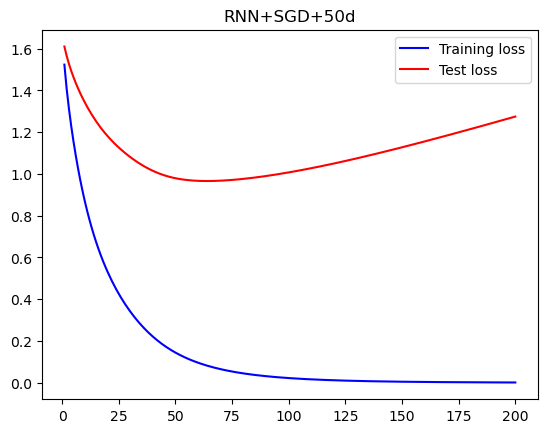

In [181]:
model = ModelBasedRNN()

epoch_repeat = 200

train_loss = [0] * epoch_repeat
test_loss = [0] * epoch_repeat

predictions = []

for i in range(epoch_repeat):
    for j in range(len(train_sentences)):
        model.train(train_sentences[j], train_labels[j])
        
    for j in range(len(train_sentences)):
        prediction = model.test(train_sentences[j])
        train_loss[i] += cross_entropy_loss(train_labels[j], prediction)
    train_loss[i] /= len(train_sentences)
    
    prediction_set = []
    
    for j in range(len(test_sentences)):
        prediction = model.test(test_sentences[j])
        test_loss[i] += cross_entropy_loss(test_labels[j], prediction)
        prediction_set.append(np.argmax(prediction))
    test_loss[i] /= len(test_sentences)
    predictions.append(prediction_set)

print(np.argmin(test_loss), np.min(test_loss))

epochs = range(1, epoch_repeat + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('RNN+SGD+50d')
plt.legend()
plt.show()

In [182]:
prediction = np.array(predictions[np.argmin(test_loss)])
print('accuracy:', np.average(test_labels_not_encoded == prediction))

emo_utils.print_predictions(test_sentences, prediction)

accuracy: 0.625

i want to eat 🍴
he did not answer 😄
he got a very nice raise 😄
she got me a nice present 😞
ha ha ha it was so funny 😄
he is a good friend 😄
i am upset 😞
we had such a lovely dinner tonight 😄
where is the food 🍴
stop making this joke ha ha ha 😄
where is the ball ⚾
work is hard 😄
this girl is messing with me 😄
are you serious 😞
let us go play baseball ⚾
this stupid grader is not working  😄
work is horrible 😄
congratulation for having a baby ❤️
stop pissing me off 😞
any suggestions for dinner 😞
i love taking breaks ❤️
you brighten my day 😄
i boiled rice 🍴
she is a bully ❤️
why are you feeling bad 😞
i am upset 😞
give me the ball ❤️
my grandmother is the love of my life 😞
enjoy your game ⚾
valentine day is near 🍴
i miss you so much ❤️
throw the ball ⚾
my life is so boring 😄
she said yes 😄
will you be my valentine 😞
he can pitch really well ⚾
dance with me 😄
i am hungry 🍴
see you at the restaurant 🍴
i like to laugh ❤️
i will  run ⚾
i like your jacket  ❤️
i miss her ❤️
what i

47 0.7520517191043591


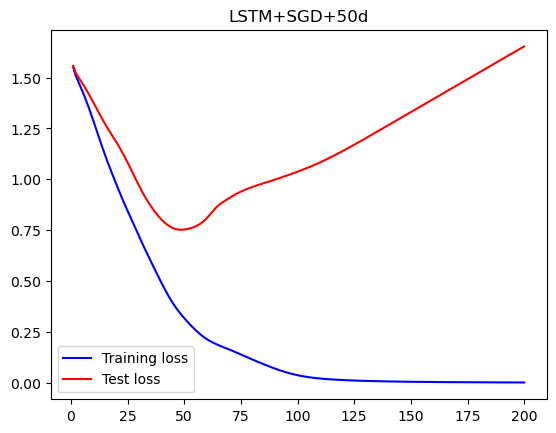

In [183]:
model = ModelBasedLSTM(adam=False, glove=50, dropout=False)

epoch_repeat = 200

train_loss = [0] * epoch_repeat
test_loss = [0] * epoch_repeat

predictions = []

for i in range(epoch_repeat):
    for j in range(len(train_sentences)):
        model.train(train_sentences[j], train_labels[j])
        
    for j in range(len(train_sentences)):
        prediction = model.test(train_sentences[j])
        train_loss[i] += cross_entropy_loss(train_labels[j], prediction)
    train_loss[i] /= len(train_sentences)
    
    prediction_set = []
    
    for j in range(len(test_sentences)):
        prediction = model.test(test_sentences[j])
        test_loss[i] += cross_entropy_loss(test_labels[j], prediction)
        prediction_set.append(np.argmax(prediction))
    test_loss[i] /= len(test_sentences)
    predictions.append(prediction_set)

print(np.argmin(test_loss), np.min(test_loss))

epochs = range(1, epoch_repeat + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('LSTM+SGD+50d')
plt.legend()
plt.show()

In [184]:
prediction = np.array(predictions[np.argmin(test_loss)])
print('accuracy:', np.average(test_labels_not_encoded == prediction))

emo_utils.print_predictions(test_sentences, prediction)

accuracy: 0.75

i want to eat 🍴
he did not answer 😞
he got a very nice raise 😄
she got me a nice present ❤️
ha ha ha it was so funny 😄
he is a good friend 😄
i am upset 😞
we had such a lovely dinner tonight 😄
where is the food 🍴
stop making this joke ha ha ha 😄
where is the ball ⚾
work is hard 😄
this girl is messing with me ❤️
are you serious 😞
let us go play baseball ⚾
this stupid grader is not working  😞
work is horrible 😄
congratulation for having a baby 😄
stop pissing me off 😞
any suggestions for dinner 😞
i love taking breaks ❤️
you brighten my day 😞
i boiled rice 🍴
she is a bully ❤️
why are you feeling bad 😞
i am upset 😞
give me the ball ⚾
my grandmother is the love of my life ❤️
enjoy your game ⚾
valentine day is near 😄
i miss you so much ❤️
throw the ball ⚾
my life is so boring 😞
she said yes 😄
will you be my valentine 😞
he can pitch really well ⚾
dance with me 😄
i am hungry 🍴
see you at the restaurant ⚾
i like to laugh ❤️
i will  run ⚾
i like your jacket  ❤️
i miss her ❤️
what i

18 0.9870698378209383


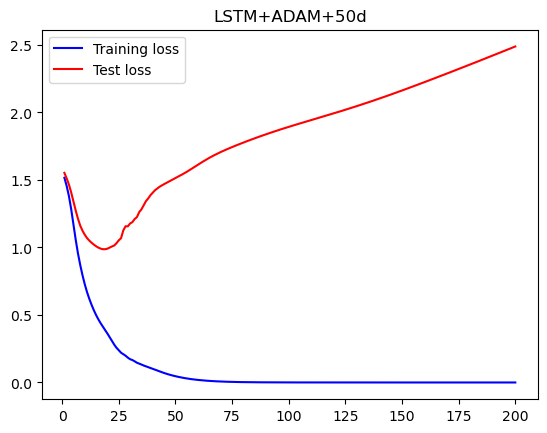

In [185]:
model = ModelBasedLSTM(adam=True, glove=50, dropout=False)

epoch_repeat = 200

train_loss = [0] * epoch_repeat
test_loss = [0] * epoch_repeat

predictions = []

for i in range(epoch_repeat):
    for j in range(len(train_sentences)):
        model.train(train_sentences[j], train_labels[j])
        
    for j in range(len(train_sentences)):
        prediction = model.test(train_sentences[j])
        train_loss[i] += cross_entropy_loss(train_labels[j], prediction)
    train_loss[i] /= len(train_sentences)
    
    prediction_set = []
    
    for j in range(len(test_sentences)):
        prediction = model.test(test_sentences[j])
        test_loss[i] += cross_entropy_loss(test_labels[j], prediction)
        prediction_set.append(np.argmax(prediction))
    test_loss[i] /= len(test_sentences)
    predictions.append(prediction_set)

print(np.argmin(test_loss), np.min(test_loss))

epochs = range(1, epoch_repeat + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('LSTM+ADAM+50d')
plt.legend()
plt.show()

In [186]:
prediction = np.array(predictions[np.argmin(test_loss)])
print('accuracy:', np.average(test_labels_not_encoded == prediction))

emo_utils.print_predictions(test_sentences, prediction)

accuracy: 0.6964285714285714

i want to eat 🍴
he did not answer 😞
he got a very nice raise 😄
she got me a nice present ❤️
ha ha ha it was so funny 😄
he is a good friend 😄
i am upset 😞
we had such a lovely dinner tonight 😄
where is the food 🍴
stop making this joke ha ha ha 😄
where is the ball ⚾
work is hard 😄
this girl is messing with me ❤️
are you serious 😞
let us go play baseball ⚾
this stupid grader is not working  😞
work is horrible 😄
congratulation for having a baby 😄
stop pissing me off 😞
any suggestions for dinner 😄
i love taking breaks ❤️
you brighten my day ❤️
i boiled rice 🍴
she is a bully 😄
why are you feeling bad 😞
i am upset 😞
give me the ball 😞
my grandmother is the love of my life ❤️
enjoy your game 😄
valentine day is near 😄
i miss you so much ❤️
throw the ball ⚾
my life is so boring 😄
she said yes 😄
will you be my valentine ❤️
he can pitch really well ⚾
dance with me 😄
i am hungry 🍴
see you at the restaurant ⚾
i like to laugh ❤️
i will  run ⚾
i like your jacket  ❤️
i mis

39 0.8433332150705551


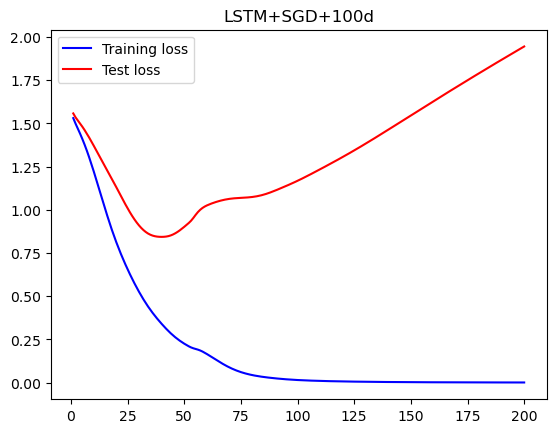

In [187]:
model = ModelBasedLSTM(adam=False, glove=100, dropout=False)

epoch_repeat = 200

train_loss = [0] * epoch_repeat
test_loss = [0] * epoch_repeat

predictions = []

for i in range(epoch_repeat):
    for j in range(len(train_sentences)):
        model.train(train_sentences[j], train_labels[j])
        
    for j in range(len(train_sentences)):
        prediction = model.test(train_sentences[j])
        train_loss[i] += cross_entropy_loss(train_labels[j], prediction)
    train_loss[i] /= len(train_sentences)
    
    prediction_set = []
    
    for j in range(len(test_sentences)):
        prediction = model.test(test_sentences[j])
        test_loss[i] += cross_entropy_loss(test_labels[j], prediction)
        prediction_set.append(np.argmax(prediction))
    test_loss[i] /= len(test_sentences)
    predictions.append(prediction_set)

print(np.argmin(test_loss), np.min(test_loss))

epochs = range(1, epoch_repeat + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('LSTM+SGD+100d')
plt.legend()
plt.show()

In [188]:
prediction = np.array(predictions[np.argmin(test_loss)])
print('accuracy:', np.average(test_labels_not_encoded == prediction))

emo_utils.print_predictions(test_sentences, prediction)

accuracy: 0.6428571428571429

i want to eat 🍴
he did not answer 😞
he got a very nice raise ❤️
she got me a nice present ❤️
ha ha ha it was so funny 😄
he is a good friend ❤️
i am upset 😞
we had such a lovely dinner tonight ❤️
where is the food 🍴
stop making this joke ha ha ha 😄
where is the ball ⚾
work is hard 😄
this girl is messing with me ❤️
are you serious 😞
let us go play baseball ⚾
this stupid grader is not working  😞
work is horrible 😄
congratulation for having a baby 😄
stop pissing me off 😞
any suggestions for dinner 😄
i love taking breaks ❤️
you brighten my day 😞
i boiled rice 🍴
she is a bully ❤️
why are you feeling bad 😞
i am upset 😞
give me the ball 😞
my grandmother is the love of my life ❤️
enjoy your game ⚾
valentine day is near 😄
i miss you so much ❤️
throw the ball ⚾
my life is so boring 😞
she said yes 😄
will you be my valentine 😞
he can pitch really well ⚾
dance with me 😄
i am hungry 😞
see you at the restaurant ⚾
i like to laugh 🍴
i will  run ⚾
i like your jacket  ❤️
i mi

107 0.8270725822594925


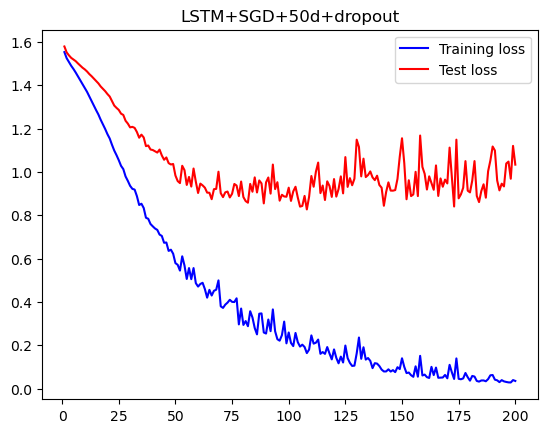

In [189]:
model = ModelBasedLSTM(adam=False, glove=50, dropout=True)

epoch_repeat = 200

train_loss = [0] * epoch_repeat
test_loss = [0] * epoch_repeat

predictions = []

for i in range(epoch_repeat):
    for j in range(len(train_sentences)):
        model.train(train_sentences[j], train_labels[j])
        
    for j in range(len(train_sentences)):
        prediction = model.test(train_sentences[j])
        train_loss[i] += cross_entropy_loss(train_labels[j], prediction)
    train_loss[i] /= len(train_sentences)
    
    prediction_set = []
    
    for j in range(len(test_sentences)):
        prediction = model.test(test_sentences[j])
        test_loss[i] += cross_entropy_loss(test_labels[j], prediction)
        prediction_set.append(np.argmax(prediction))
    test_loss[i] /= len(test_sentences)
    predictions.append(prediction_set)

print(np.argmin(test_loss), np.min(test_loss))

epochs = range(1, epoch_repeat + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('LSTM+SGD+50d+dropout')
plt.legend()
plt.show()

In [190]:
prediction = np.array(predictions[np.argmin(test_loss)])
print('accuracy:', np.average(test_labels_not_encoded == prediction))

emo_utils.print_predictions(test_sentences, prediction)

accuracy: 0.6964285714285714

i want to eat 🍴
he did not answer 😞
he got a very nice raise 😄
she got me a nice present ❤️
ha ha ha it was so funny 😄
he is a good friend 😄
i am upset 😞
we had such a lovely dinner tonight 😄
where is the food 🍴
stop making this joke ha ha ha 😞
where is the ball ⚾
work is hard 😄
this girl is messing with me ❤️
are you serious 😞
let us go play baseball ⚾
this stupid grader is not working  😞
work is horrible 😄
congratulation for having a baby 😄
stop pissing me off 😞
any suggestions for dinner 😄
i love taking breaks ❤️
you brighten my day 😞
i boiled rice 🍴
she is a bully ❤️
why are you feeling bad 😞
i am upset 😞
give me the ball ⚾
my grandmother is the love of my life ❤️
enjoy your game 😄
valentine day is near 😄
i miss you so much ❤️
throw the ball ⚾
my life is so boring 😞
she said yes 😄
will you be my valentine 😞
he can pitch really well ⚾
dance with me 😄
i am hungry 🍴
see you at the restaurant ⚾
i like to laugh 😄
i will  run ⚾
i like your jacket  ❤️
i miss 